In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import seaborn as sns

# This sis the main function we will use to simulation data based on 3 parameters:

# 1. time to take for taking one shotting attempt on average (in seconds)
# 2. two point shooting percentage (%)
# 3. three point shooting percentage (%)

In [6]:
def hundred_points(interval=30,two_point_percentatge=1.,three_point_percentage=1.,flag=False):
    total_seconds = 24 * 60
    attempts = math.floor(total_seconds / interval)
    #|print('total attempts = % d'%attempts)
    two_point_attempts = np.arange(0,attempts + 1, 1)
    three_point_attempts = attempts - two_point_attempts
    scores = two_point_attempts * 2 * two_point_percentatge + three_point_attempts * 3 * three_point_percentage
    if flag:
        fig,ax = plt.subplots(figsize=(16,8))
        ax.plot(two_point_attempts,scores,'-*')
        ax.axhline(100,linestyle = '--')
        _=ax.set(xticks=two_point_attempts,xlabel='two-point attempts',ylabel='Total score if make all shots',
                title='at least take % d 3 pts'% (attempts - two_point_attempts[abs(scores - 100) <0.5][0]))
    return [[(0,100),(two_point_attempts[-1],100)],[(two_point_attempts[0],scores[0]),(two_point_attempts[-1],scores[-1])],attempts]
    #return scores,two_point_attempts

# Here is an example for demonstration: if we take a shoot every 30 seconds (on average), so, for 24 minutes, we will have 48 possible attempts. How do we distribute the attempts to two points and three's so that we will score 100 points? What if we have 70% shooting percentage on both two's and three's?


Looking at the figure below:
1. At the two ends of the firm line, if we only take three's, which means we don't take any two's, we could have a bit above 100 (which is 100.8, and we have to round the number to floor, so we only can get 100 points). If we only take two's, which means we take 48 two's attempts, we could make 70% of them, and we will have 67 points, which is way below 100. 
2. Therefore, in the spirit of simulation, I will test all the possible combinations of time interval (seconds to take for making a shooting attempt on average), two point percentage, and three point percentage. 
3. We will examine all the results, and if the combination of the three parameters could not generate a line that intersect that dash line passing "100", we will throw away that data. 

total attempts =  48


[[(0, 100), (48, 100)], [(0, 100.8), (48, 67.199999999999989)], 48]

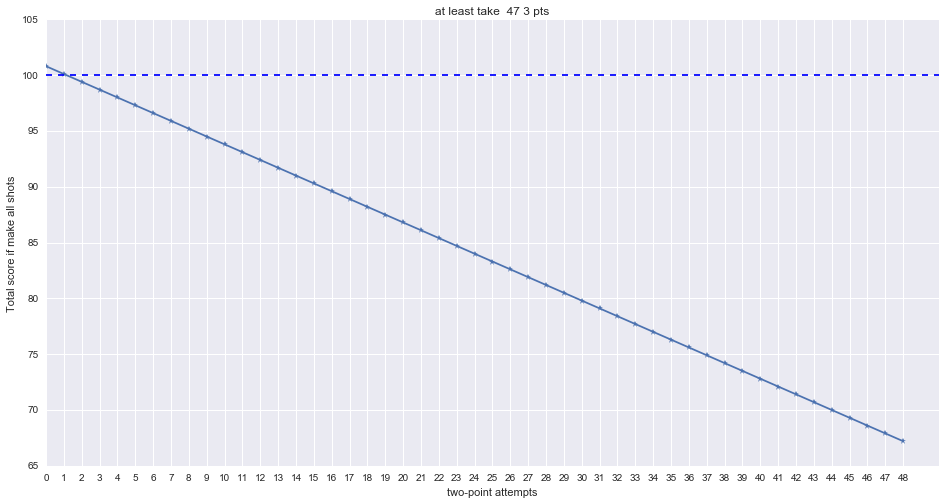

In [3]:
hundred_points(30,.7,.7,True)

# This is a function we use to compute the intersection of two lines (found online)

In [4]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1]) #Typo was here

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    if ((l2[1][1] - l2[0][1]) < 0).astype(int):
        if (x > line1[1][0]) :
            return 'over' # should be 'always'
        elif x < 0:
            return 'less' # should be 'never'
        else:
            return x, y
    else:
        if (x > line1[1][1]) :
            return 'less' # should be 'never'
        elif x < 0:
            return 'over' # should be 'always'
        else:
            return x, y


# Parameter space:

# 1. intervals: from 10 seconds/attempt to 60 seconds/attempt
# 2. two point %: 36% to 86%
# 3. three point %: 33% to 86%

# Intuition before the simulation: Warriors in season 2015-2016 scored every 25 seconds and they had made around 50% two's and 45% three's

In [7]:
result = []
intervals = np.arange(10,60,1)
two_point_ptgs = np.arange(.36,.86,0.05)
three_point_ptgs = np.arange(.33,.86,0.03)
for interval in intervals:
    for two_point_ptg in two_point_ptgs:
        for three_point_ptg in three_point_ptgs:
            try:
                l1,l2,attempts=hundred_points(interval,two_point_ptg,three_point_ptg)
                slope = ((l2[1][1] - l2[0][1]) > 0).astype(int)
                result.append([interval,two_point_ptg,three_point_ptg,line_intersection(l1,l2)[0],slope,attempts])
            except:
                pass

# After a full simulation, I have to take a close look at the table, and rule out those don't fit what we need. 

In [8]:
intersect=[]
for item in result:
    if (item[-3] is 'l') or (item[-3] is 'o') :
        pass
    else:
        intersect.append([item[0],item[1],item[2],int(item[-3]),item[-2],item[-1]])

import pandas as pd
intersect = pd.DataFrame(intersect,
                         columns=['interval','two_point_ptg','three_point_ptg','taking_twos','slop','all_attempts'])
intersect['minimum_threes'] = intersect['all_attempts'] - intersect['taking_twos']
intersect = intersect[intersect['minimum_threes'] > 0]

# Here is one way to measure effective field goal percentage, which takes account of both two's and three's

In [10]:
intersect['eFG%']=((intersect['two_point_ptg']*intersect['taking_twos']+
                    intersect['three_point_ptg']*intersect['minimum_threes'])+
                 0.5 * intersect['three_point_ptg']*intersect['minimum_threes'])/intersect['all_attempts']

In [11]:
intersect.head()

,interval,two_point_ptg,three_point_ptg,taking_twos,slop,all_attempts,minimum_threes,eFG%
0,11,0.36,0.33,106,0,130,24,0.384923
1,11,0.36,0.36,112,0,130,18,0.384923
2,11,0.36,0.39,115,0,130,15,0.385962
3,11,0.36,0.42,118,0,130,12,0.384923
4,11,0.36,0.45,119,0,130,11,0.386654


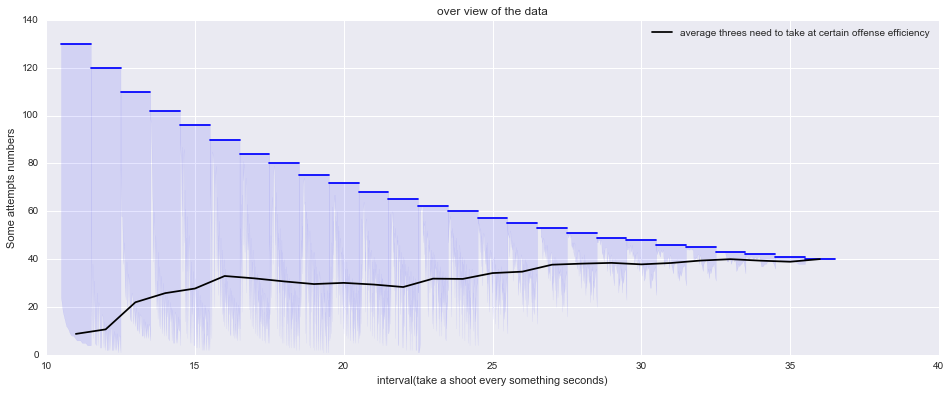

In [16]:
plt.close('all')
fig,ax = plt.subplots(figsize=(16,6))
yy=[]
for interval in pd.unique(intersect['interval']):
    temp_df = intersect[intersect['interval']==interval]
    temp_df=temp_df.sort_values(by=['three_point_ptg'])
    xx = np.linspace(interval - 0.5, interval + 0.5,len(temp_df))
    ax.fill_between(xx,temp_df['all_attempts']-temp_df['taking_twos'],
                 temp_df['all_attempts'],temp_df['minimum_threes'],alpha=0.1,color='blue')
    ax.plot(xx,temp_df['all_attempts'],alpha=1.,color='b',label='')
    yy.append(np.mean(temp_df['all_attempts']-temp_df['taking_twos']))
ax.plot(pd.unique(intersect['interval']),yy,alpha=1.,color='k',label='average threes need to take at certain offense efficiency')
ax.set(xlabel='interval(take a shoot every something seconds)',title='over view of the data',ylabel='Some attempts numbers')
ax.legend(loc='best')

As we observed above, the wider (from bottom to the top), the more numbers of two's you might consider to take. Intuitively, when you score every 15 seconds, compared to when you score every 30 seconds, you don't need to take many three's, regardless the shooting percentage.

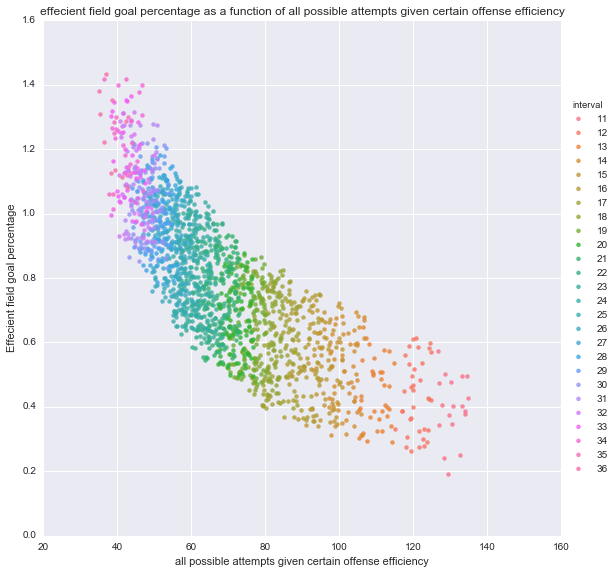

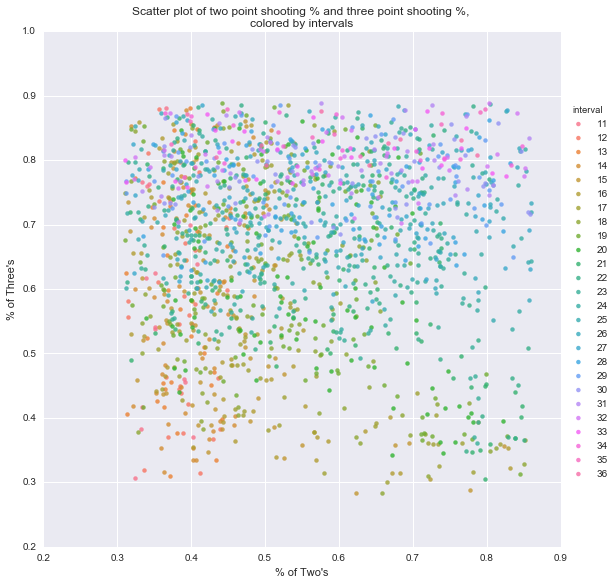

In [40]:
ax=sns.lmplot(x='all_attempts', y="eFG%",hue='interval', data=intersect, x_jitter=5.,fit_reg=False,
          size=8,y_jitter=0.2)
ax.set(title='effecient field goal percentage as a function of all possible attempts given certain offense efficiency',
      ylabel='Effecient field goal percentage',xlabel='all possible attempts given certain offense efficiency')
ax=sns.lmplot(x='two_point_ptg', y="three_point_ptg",hue='interval', data=intersect, x_jitter=.05,y_jitter=0.05,
           fit_reg=False,size=8)

ax.set(title='Scatter plot of two point shooting % and three point shooting %, \ncolored by intervals',
      xlabel="% of Two's", ylabel="% of Three's")